# Temperature bias maps

Note, I am using 47 cores and 190Gb memory for this calculation.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean as cm
import pandas as pd
import cftime
from dask.distributed import Client

In [2]:
## To implement, use:
client = Client()#(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:42463 Dashboard: /proxy/8787/status,Cluster Workers: 47 Cores: 47 Memory: 188.57 GiB


In [3]:
session = cc.database.create_session()

## Parameters

In [4]:
# This is for tropical and subtropical Pacific
lons = slice(-230, -70)  
lats = slice(-55, 55)
depths = np.arange(100, 601, 50)
tr_start = 1999
tr_end = 2018
trstr = str(tr_start)+'-'+str(tr_end)
time_range = slice(str(tr_start)+'-01-01', str(tr_end)+'-12-31')

timewindow = 10
# timestart = range(1958, 2019, timewindow)
# timeend = timestart + timewindow
times = [ slice(str(y)+'-01-01', str(y+timewindow-1)+'-12-31') 
         for y in range(1958, 2019, timewindow)[:-1] ]
timestrs = [ str(y)+'-'+str(y+timewindow-1)
         for y in range(1958, 2019, timewindow)[:-1] ]

KELVIN_TO_CELSIUS = -273.15

## Load data

In [5]:
expt = '01deg_jra55v140_iaf'
temp = cc.querying.getvar(expt, 'temp', session, ncfile='ocean-3d-temp-1-monthly-mean-ym_%.nc')
temperature = temp.sel(yt_ocean=lats).sel(xt_ocean=lons)

In [6]:
# Load obs 
ds_obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/01/woa13_ts_??_mom01.nc')
ds_obs = ds_obs.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
ds_obs['st_ocean'] = temp.st_ocean
ds_obs['xt_ocean'] = temp.xt_ocean
ds_obs['yt_ocean'] = temp.yt_ocean
ds_obs = ds_obs.sel(yt_ocean=lats).sel(xt_ocean=lons)
temperature_obs = ds_obs.temp

## Plot maps for each depth

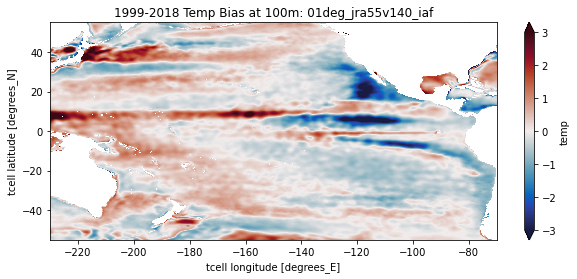

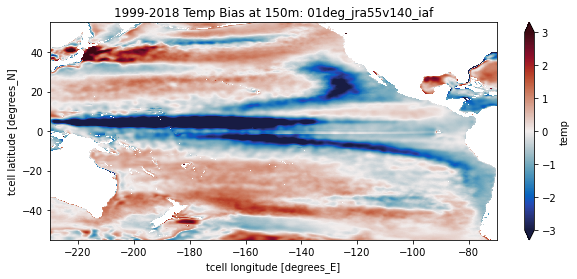

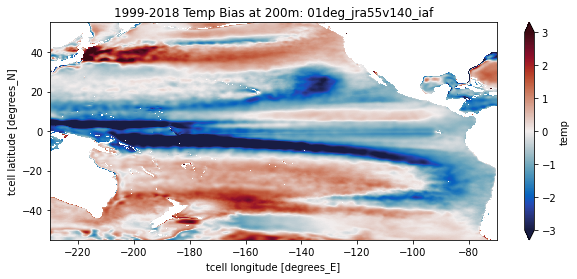

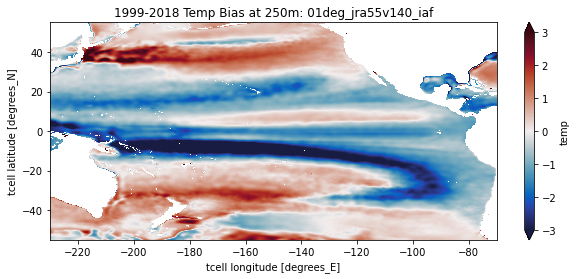

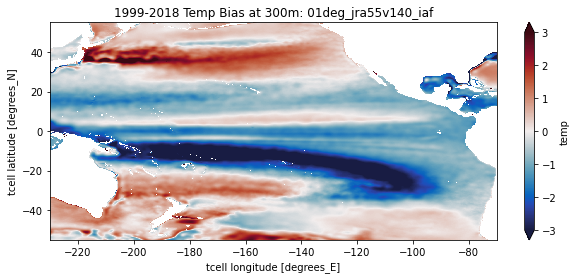

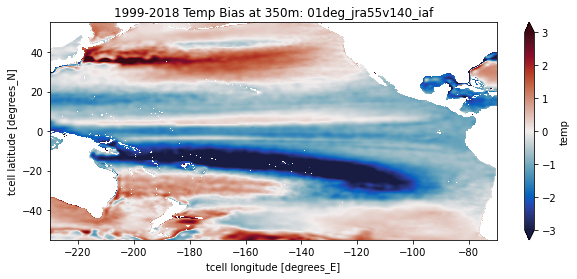

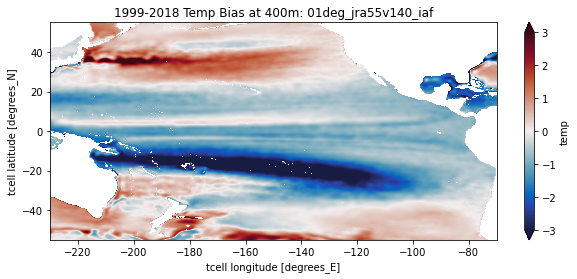

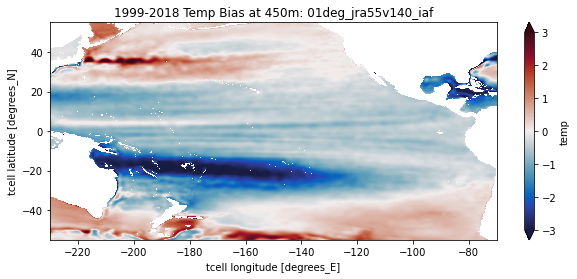

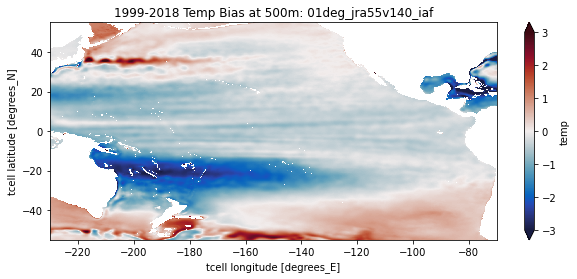

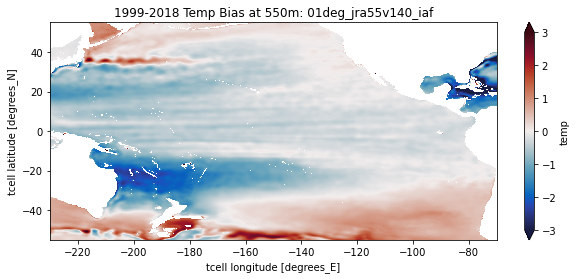

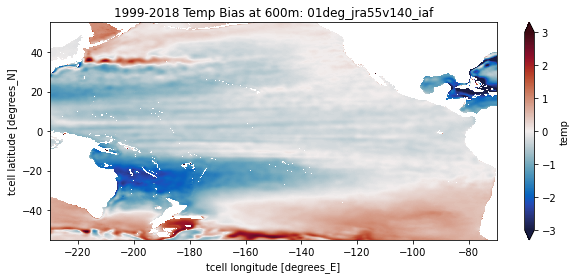

In [7]:
for d in depths:
    plt.figure(figsize=(10,4))
    bias = (temperature.sel(st_ocean=d, method='nearest').sel(time=time_range).mean('time')\
            - temperature_obs.sel(st_ocean=d, method='nearest').mean('time'))\
            + KELVIN_TO_CELSIUS
    bias.plot(vmin=-3, vmax=3,cmap = cm.cm.balance)
    plt.title(trstr+' Temp Bias at '+str(d)+'m: '+expt)

## Plot maps vs. time at one depth

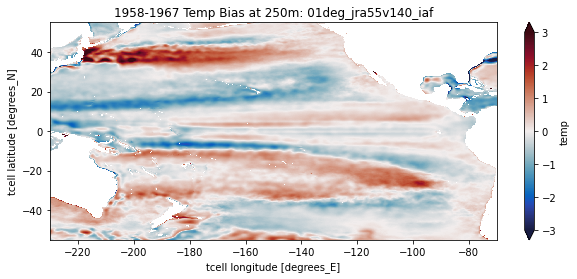

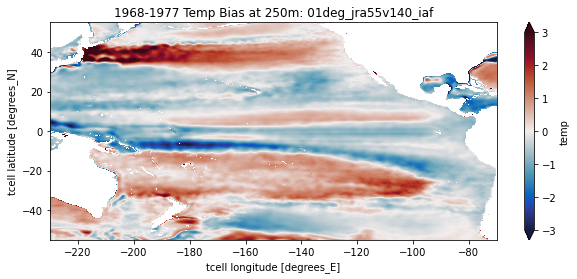

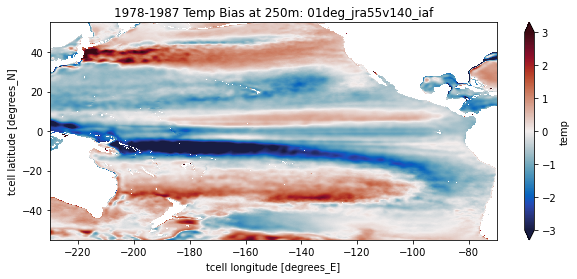

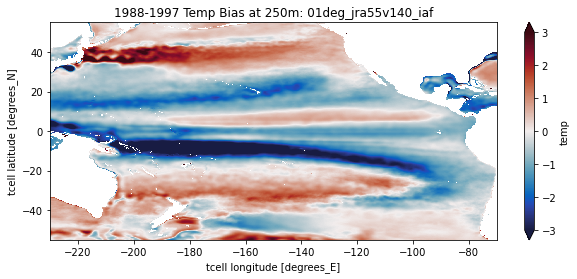

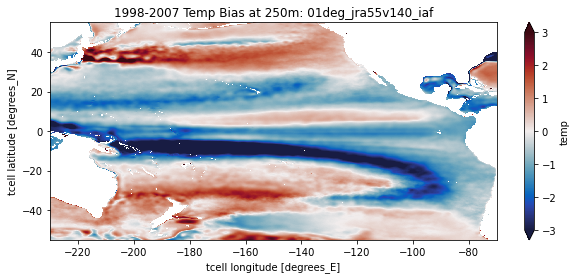

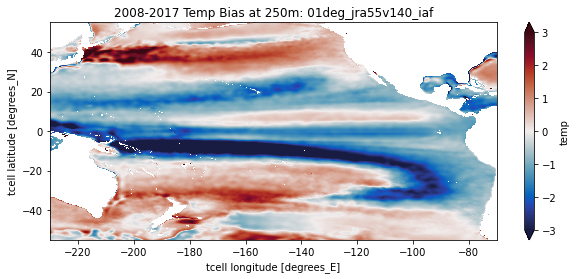

In [8]:
d = 250
for t, tstr in zip(times, timestrs):
    plt.figure(figsize=(10,4))
    bias = (temperature.sel(st_ocean=d, method='nearest').sel(time=t).mean('time')\
            - temperature_obs.sel(st_ocean=d, method='nearest').mean('time'))\
            + KELVIN_TO_CELSIUS
    bias.plot(vmin=-3, vmax=3,cmap = cm.cm.balance)
    plt.title(tstr+' Temp Bias at '+str(d)+'m: '+expt)